In [14]:
############################################################
# GeoHack 2023 Automated Fire Perimiter
#
#Provides functions to:
# 1.1 > Classify Raster
#     > Raster to Vector
#     > ??? Project Vectors ???
#     > Aggregate Polygons
#     > Split
#     > Combine
#
#Information:
#     Automated Fire Perimeter model using classification and
#     transformation techniques to rapidly build a fire
#     shape file. This model reduces noise and accounts for
#     layers of human subjectivity based on industry defined
#     threshold. Prectical applications for fire inteligence
#     are situational awareness of fire growth in a near 
#     real time environment. Each succesive update offers 
#     a POI for AI fire pretiction models from other platforms
# 
# Acknowledgments: GeoHack 2023 Team 1 ("Names/Country Here")
#       > Info:>>>    
# By: Tony Ramos
# Date: 03/10/2023
#
############################################################

In [15]:
import os
import rasterio
import shapely
import numpy as np
import geopandas as gpd
import scipy
import fiona
import matplotlib.pyplot as plt

from rasterio import features
from matplotlib import pyplot
from shapely.ops import unary_union
from shapely.geometry import MultiPolygon, Polygon


In [16]:
# File Path

work_dir = "./data/"
image = os.path.join(work_dir, "LWIR_QuickMosaic_16-bit_9327.tiff")
poly = os.path.join(work_dir, "HeatPoly.shp")
# work_dir ="Data"
# MillsFire="C:/Users/centr/GeoHack23-WildfirePerimeter/Data/LWIR_QuickMosaic_16-bit_9327.tiff"
OutputFilePath ="./data/"

In [17]:
# Open the raster file using rasterio
KneeThresh = 33332
with rasterio.open(image) as src:
    # Read the raster data and metadata
    raster_data = src.read(1)  # Read the first band of the raster
    raster_meta = src.meta

    # Classify the raster data
    classified_data = np.where(raster_data < KneeThresh, 0, 1)

# Update the metadata with the new data type and nodata value
raster_meta.update(dtype=rasterio.uint8, nodata=None)

# Write the classified raster to a new file
with rasterio.open(OutputFilePath + 'RasterClass.tif', 'w', **raster_meta) as dst:
    dst.write(classified_data.astype(rasterio.uint16), 1)


In [18]:
# Open the raster file using rasterio
with rasterio.open(image) as src:
    # Read the raster data and metadata
    raster_data = src.read(1)  # Read the first band of the raster
    raster_meta = src.meta

    # Classify the raster data
    classified_data = np.where(raster_data < KneeThresh, 0, 1).astype(np.uint16)

# Update the metadata with the new data type and nodata value
raster_meta.update(dtype=rasterio.uint16, nodata=None)

# Write the classified raster to a new file
with rasterio.open(OutputFilePath + 'RasterClass.tif', 'w', **raster_meta) as dst:
    dst.write(classified_data, 1)

# Convert the classified raster to polygons
shapes = features.shapes(classified_data, transform=raster_meta['transform'])

# Write the polygons to a shapefile
with fiona.open(OutputFilePath + 'HeatPoly.shp', 'w', 'ESRI Shapefile',crs=fiona.crs.from_epsg(4326), schema={'geometry': 'Polygon', 'properties': {}}) as dst:
    for shape in shapes:
        value = shape[1]
        if value > 0:
            feature = {'geometry': shape[0], 'properties': {}}
            dst.write(feature)

# # (Optional) Display the polygons using matplotlib
# with fiona.open(OutputFilePath + 'HeatPoly.shp', 'r') as src:
#     for i, layer in enumerate(src):
#         if i == 0:
#             x, y = [], []
#             for poly in layer['geometry']['coordinates']:
#                 x += [pt[0] for pt in poly]
#                 y += [pt[1] for pt in poly]
#             plt.plot(x, y, 'k.')
#             plt.axis('equal')
#             plt.show()


In [19]:
# Define the source and target CRSs
src_crs = 'EPSG:4326'  # EPSG:4326 is the default CRS for the input shapefile
target_crs = 'EPSG:26910' # New projection NAD 1983 UTM Zone 10N

# Read the input shapefile into a GeoDataFrame
gdf = gpd.read_file(OutputFilePath + 'HeatPoly.shp', crs=src_crs)

# Reproject the GeoDataFrame to the target CRS
gdf = gdf.to_crs(target_crs)

# Write the reprojected GeoDataFrame to a new shapefile
gdf.to_file(OutputFilePath + 'HeatPoly_reprojected.shp', driver='ESRI Shapefile')


In [20]:
# Load your polygons into a GeoDataFrame
polygons = gpd.read_file(work_dir + 'HeatPoly_reprojected.shp')

# Set the distance within which you want to aggregate polygons
distance = 35  # in meters

# Create a buffer around each polygon using the distance
buffered = polygons.geometry.buffer(distance)

# Group buffered polygons that intersect with each other
groups = buffered.unary_union

# Convert the grouped polygons back to a GeoDataFrame
# Convert the grouped polygons back to a GeoDataFrame
if isinstance(groups, MultiPolygon):
    polygons_list = [polygon for polygon in groups.geoms]
else:
    polygons_list = [groups]

grouped_polygons = gpd.GeoDataFrame(
    {'geometry': polygons_list},
    crs=polygons.crs
)

# Save the aggregated polygons to a shapefile
grouped_polygons.to_file(OutputFilePath + 'AggrigateEx1.shp')


In [21]:
# Read in the feature class
fc = gpd.read_file(OutputFilePath + 'AggrigateEx1.shp')

# Define a minimum area threshold for interior polygons (in square units of the CRS)
threshold = 500

# Iterate over each polygon in the feature class
for index, row in fc.iterrows():
    # Get the exterior and interior polygons
    exterior = row.geometry.exterior
    interiors = row.geometry.interiors
    
    # Filter out small interior polygons
    interiors_filtered = [interior for interior in interiors if interior.area > threshold]
    
    # Create a new polygon with the filtered interiors
    filtered_polygon = type(row.geometry)(exterior, interiors_filtered)
    
    # Replace the original geometry with the filtered geometry
    fc.loc[index, 'geometry'] = filtered_polygon
    
# Save the updated feature class
fc.to_file(OutputFilePath + 'Buff.shp')

In [22]:
# Load your polygons into a GeoDataFrame
polygons = gpd.read_file(work_dir + 'Buff.shp')

# Set the distance within which you want to aggregate polygons
distance = -43  # in meters

# Create a buffer around each polygon using the distance
buffered = polygons.geometry.buffer(distance)

# Group buffered polygons that intersect with each other
groups = buffered.unary_union

# Convert the grouped polygons back to a GeoDataFrame
# Convert the grouped polygons back to a GeoDataFrame
if isinstance(groups, MultiPolygon):
    polygons_list = [polygon for polygon in groups.geoms]
else:
    polygons_list = [groups]

grouped_polygons = gpd.GeoDataFrame(
    {'geometry': polygons_list},
    crs=polygons.crs
)

# Save the aggregated polygons to a shapefile
grouped_polygons.to_file(OutputFilePath + 'NegBuff.shp')



In [23]:
# Read in the polygon shapefile
polygons = gpd.read_file(OutputFilePath + 'NegBuff.shp')

# Dissolve the polygons based on a column called 'column_name'
dissolved_polygons = polygons.dissolve(by='FID')

# Save the dissolved polygons to a new shapefile
dissolved_polygons.to_file(OutputFilePath + 'Dissolve.shp')

In [27]:
# Read in the feature class
fc = gpd.read_file(OutputFilePath + 'Dissolve.shp')

# Define a minimum area threshold for interior polygons (in square units of the CRS)
threshold = 1

# Iterate over each polygon in the feature class
for index, row in fc.iterrows():
    # Get the exterior and interior polygons
    exterior = row.geometry.exterior
    interiors = row.geometry.interiors
    
    # Filter out small interior polygons
    interiors_filtered = [interior for interior in interiors if interior.area > threshold]
    
    # Create a new polygon with the filtered interiors
    filtered_polygon = type(row.geometry)(exterior, interiors_filtered)
    
    # Replace the original geometry with the filtered geometry
    fc.loc[index, 'geometry'] = filtered_polygon
    
# Save the updated feature class
fc.to_file(OutputFilePath + 'Union.shp')

## Simplify Polygons

<Axes: >

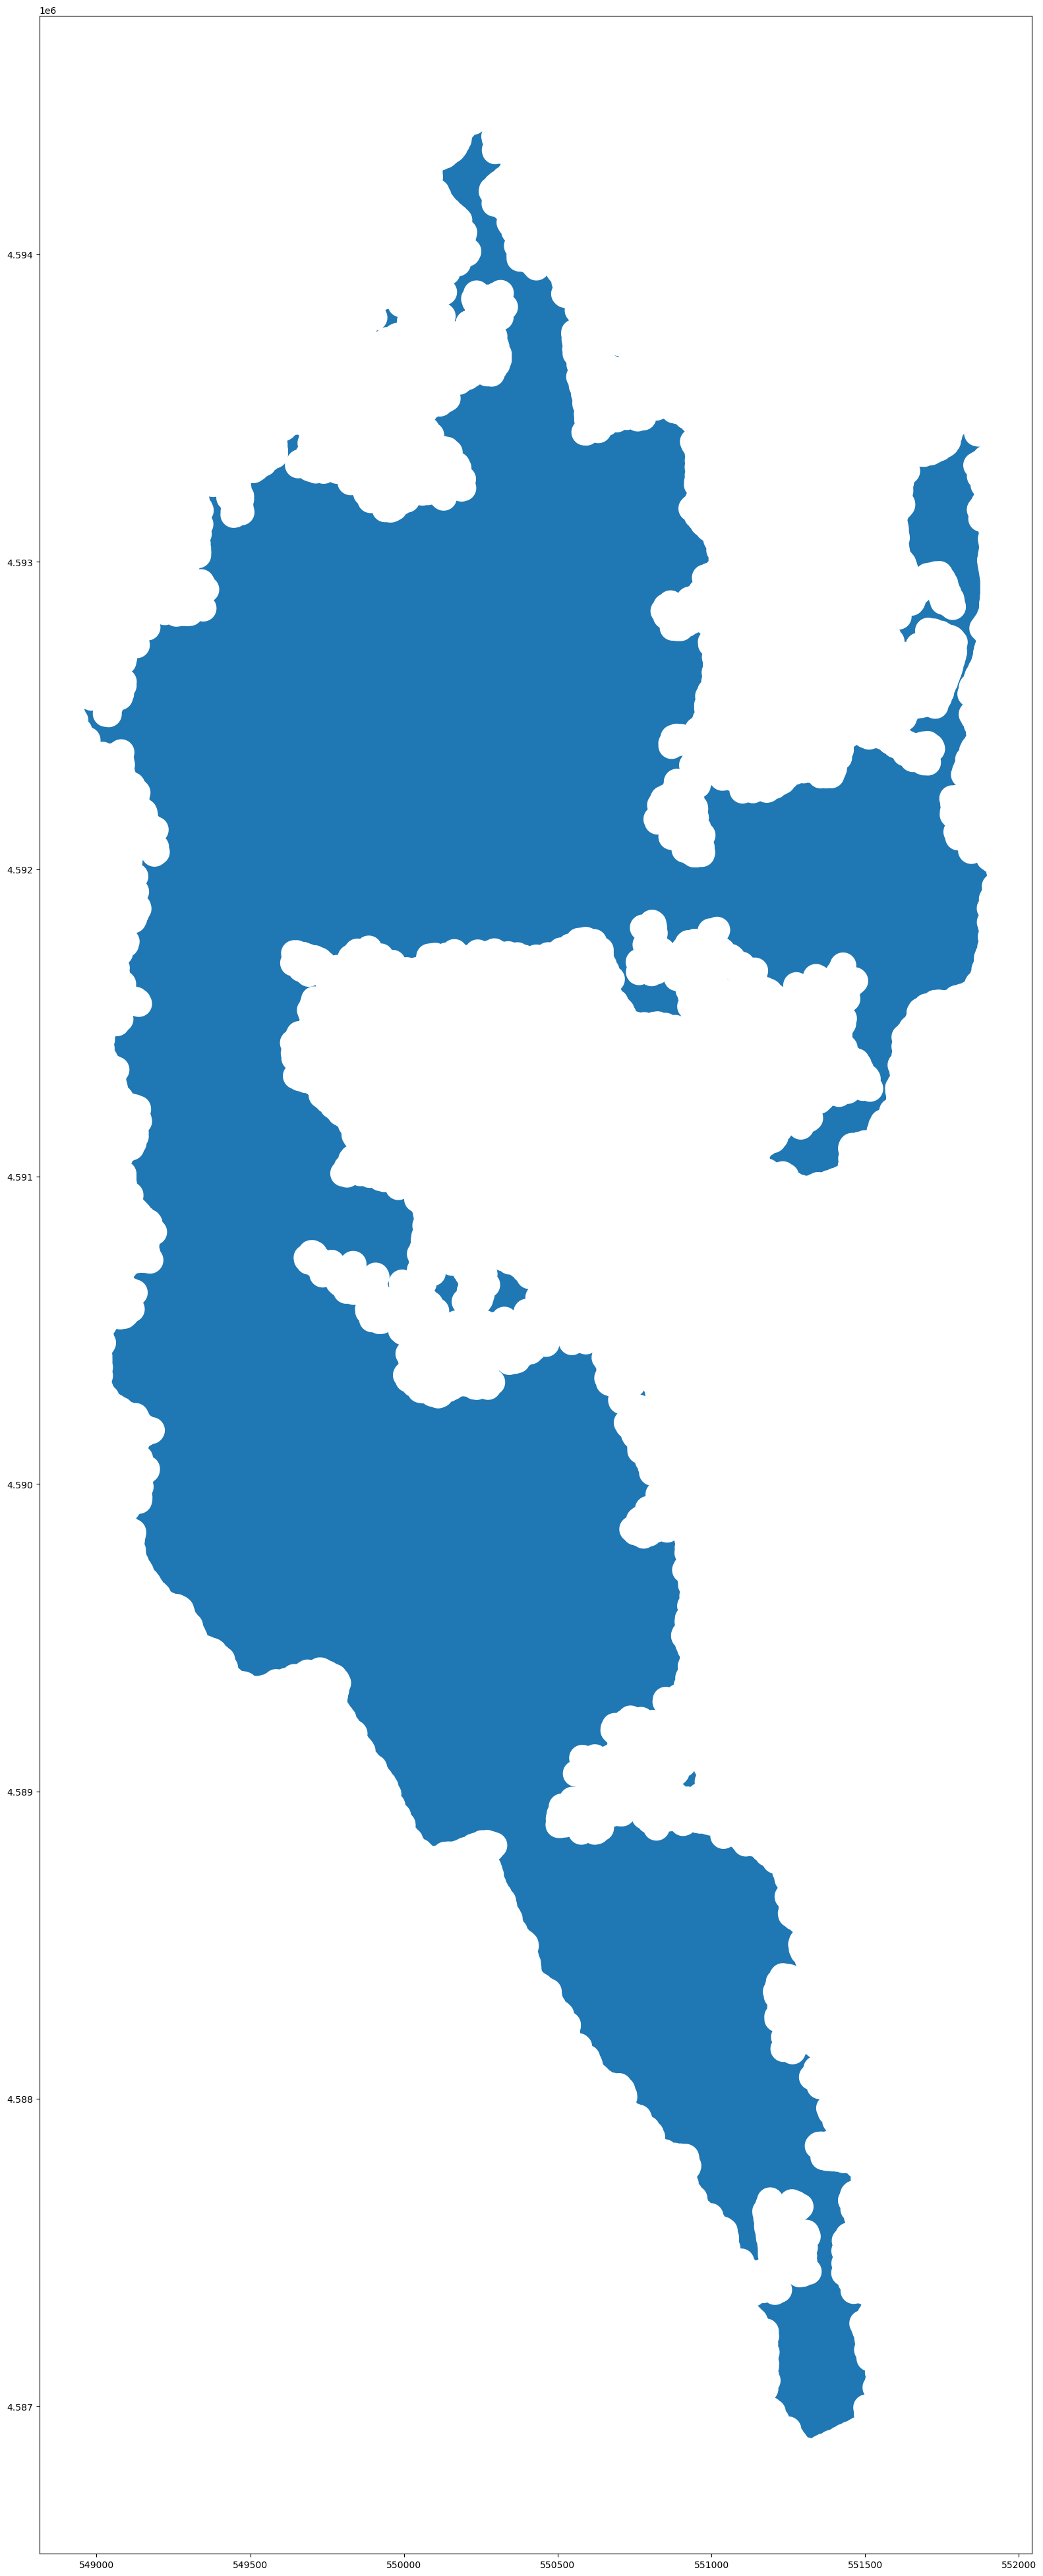

In [25]:
dissolved_polygons.plot(figsize=(50,50))

<Axes: >

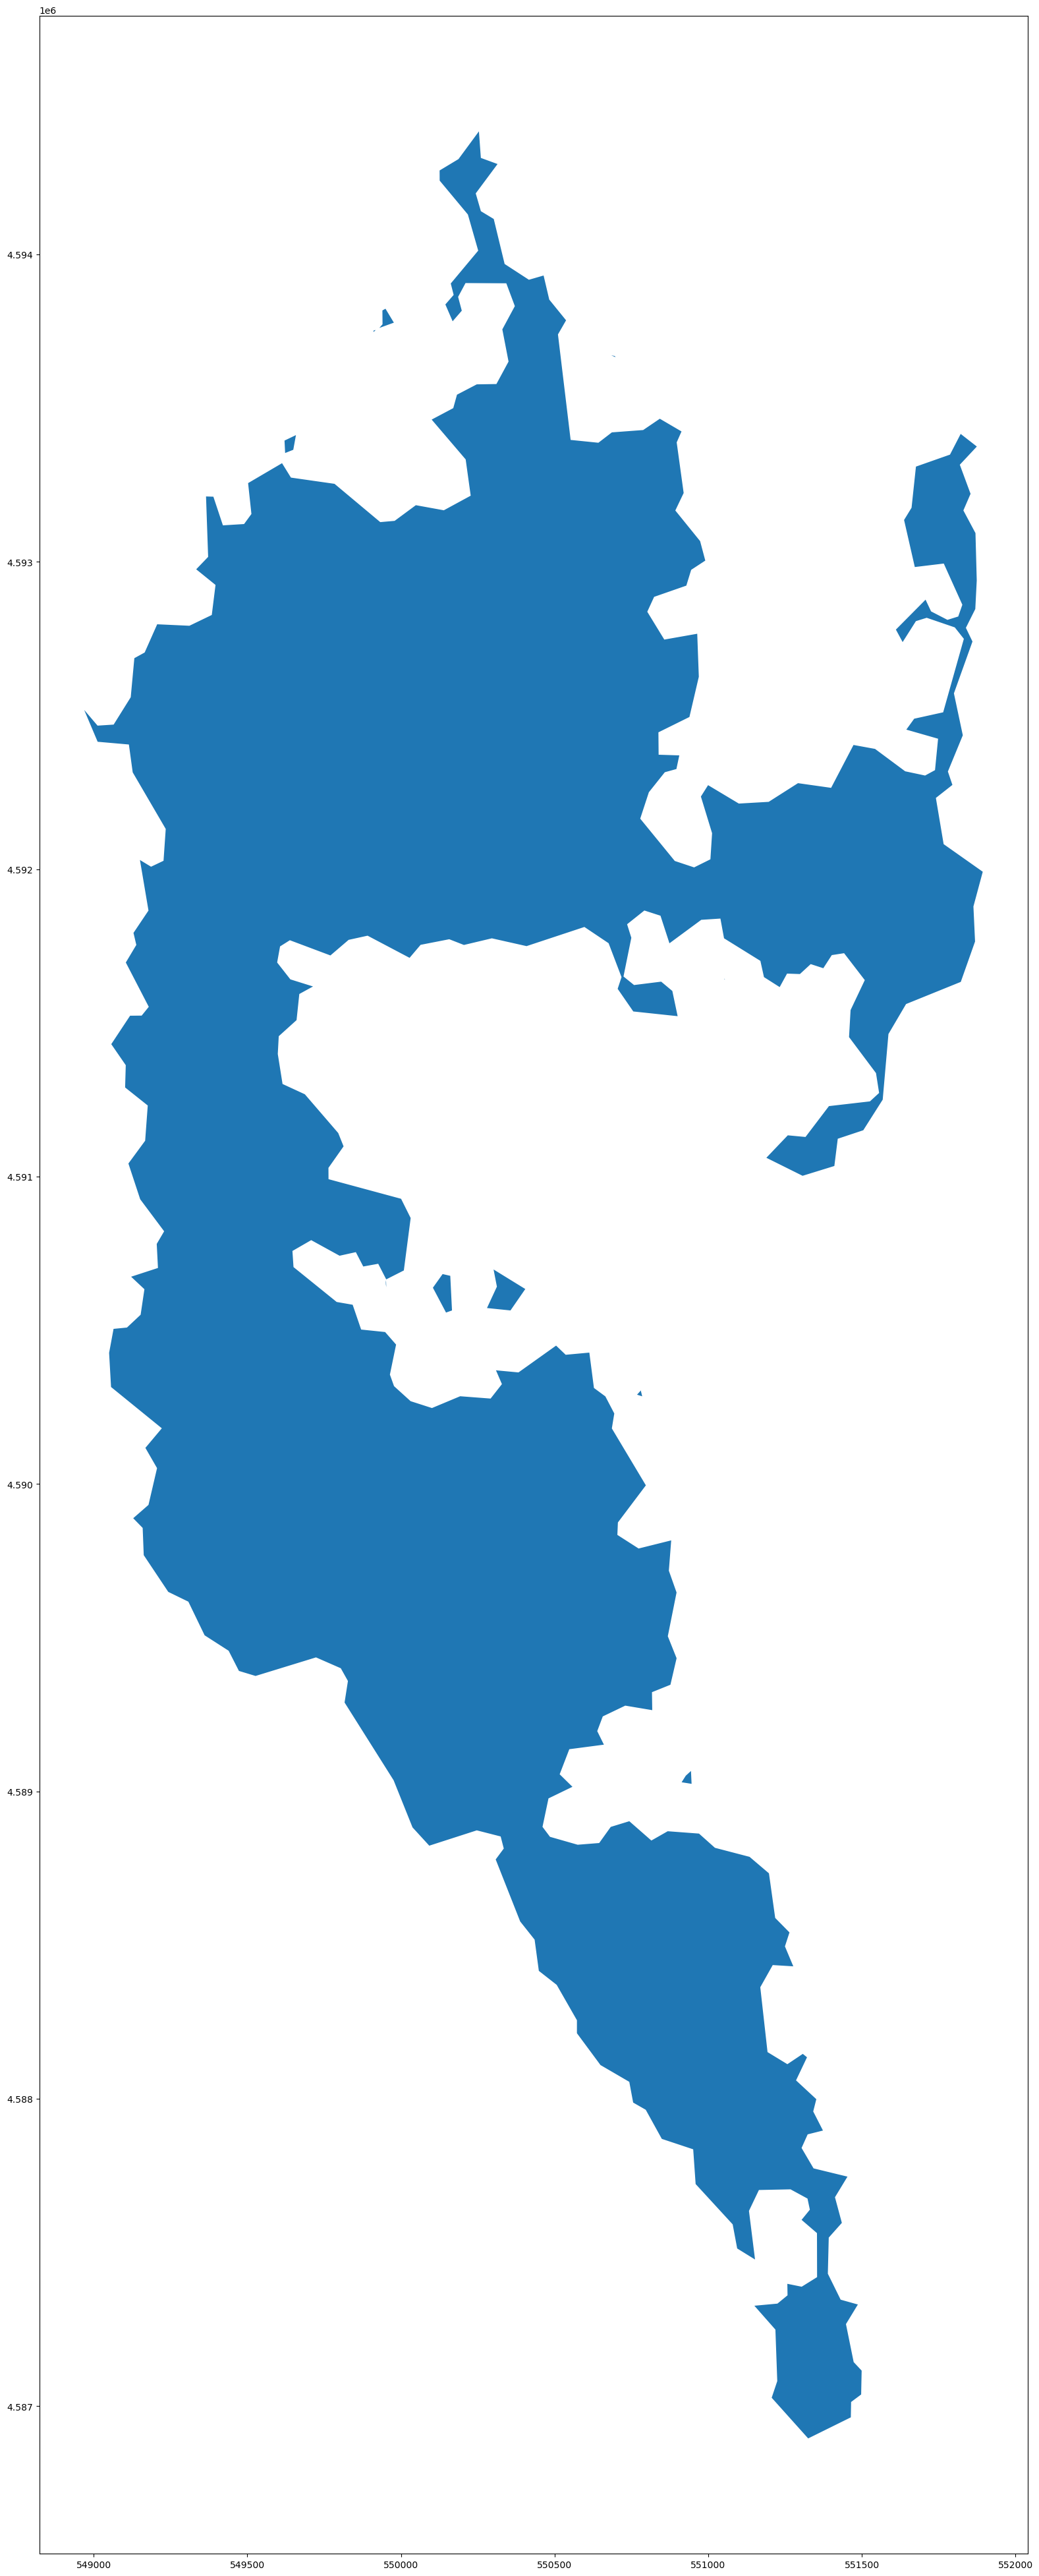

In [26]:
tolerance = 15

simplified_polygons = shapely.simplify(dissolved_polygons, tolerance=tolerance, preserve_topology=True)
simplified_polygons.to_file(OutputFilePath + 'Simplify.shp')

simplified_polygons.plot(figsize=(50,50))